# 02807 Final Project Code - Group 32

## Contributions

- **S231651 FOO YAN RONG** - Data Proprocessing, Sentiment Analysis (25%)
- **S231648 KAI JIE, JARED LIANG** - Data Proprocessing, Similariy Approach 1 (25%)
- **S231657 NELSON JIA WEI CHOO** - Data Proprocessing, Similarity Approach 2 (25%)
- **S231586 LEE JING TING** - Data Proprocessing, TF-IDF (25%)


# Data Pre-Processing

In [1]:
from imdb import Cinemagoer
import pandas as pd

In [2]:
df = pd.read_csv("box_office.csv")
df.head()

Phase                                Film  Year_Release  \
0  Phase One                            Iron Man          2008   
1  Phase One                 The Incredible Hulk          2008   
2  Phase One                          Iron Man 2          2010   
3  Phase One                                Thor          2011   
4  Phase One  Captain America: The First Avenger          2011   

  U.S. release date  Box office gross U.S. and Canada  \
0          2-May-08                         319034126   
1         13-Jun-08                         134806913   
2          7-May-10                         312433331   
3          6-May-11                         181030624   
4         22-Jul-11                         176654505   

   Box office gross Other territories  Box office gross Worldwide  \
0                           266762121                   585796247   
1                           129964083                   264770996   
2                           311500000                   623933331   
3                           268295994                   449326618   
4                           193915269                   370569774   

   All-time ranking U.S. and Canada  All-time ranking Worldwide  \
0                                79                         176   
1                               465                         593   
2                                85                         158   
3                               262                         268   
4                               279                         367   

   Rotten Tomatoes Rating CinemaScore     Budget         Director  \
0                      94           A  140000000      Jon Favreau   
1                      67          A−  150000000  Louis Leterrier   
2                      71           A  200000000      Jon Favreau   
3                      77          B+  150000000  Kenneth Branagh   
4                      79          A−  140000000     Joe Johnston   

                                  Producer  \
0                 Avi Arad and Kevin Feige   
1  Avi Arad, Gale Anne Hurdand Kevin Feige   
2                              Kevin Feige   
3                              Kevin Feige   
4                              Kevin Feige   

                                         movie_image  
0  https://upload.wikimedia.org/wikipedia/en/0/02...  
1  https://upload.wikimedia.org/wikipedia/en/f/f0...  
2  https://upload.wikimedia.org/wikipedia/en/e/ed...  
3  https://upload.wikimedia.org/wikipedia/en/9/95...  
4  https://upload.wikimedia.org/wikipedia/en/3/37...

In [3]:
movie_titles = df["Film"].tolist()
# movie_titles[:5]

In [4]:
ia = Cinemagoer()

movie_ids = {}

for mt in movie_titles:
    results = ia.search_movie(mt)
    top_result = results[0]
#     print(top_result.data['title'], top_result.movieID)
    movie_ids[mt] = top_result.movieID

In [5]:
movie_reviews = {}

for title, idx in movie_ids.items():
    movie = ia.get_movie(idx,['reviews'])
    reviews = movie['reviews']
    content = list(map(lambda x: x['content'], reviews))
    movie_reviews[title] = content

# movie_reviews

# Preprocessing / Lemmatisation / Removing Stopwords

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

# Load spaCy NER model
nlp = spacy.load("en_core_web_sm")

def keep_adjectives(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if token.pos_ in ['ADJ']]
    return " ".join(tokens)

def preprocess_text(text, keep_adjectives_flag=True):
    if keep_adjectives_flag:
        # Keep adjectives
        text = keep_adjectives(text)

    # Tokenization
    tokens = word_tokenize(text.lower())

    # Remove punctuation and numbers
    tokens = [word for word in tokens if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

# Apply preprocessing to all reviews
adj_reviews = {title: [preprocess_text(review) for review in reviews] for title, reviews in movie_reviews.items()}

# Apply preprocessing without keeping adjectives
preprocessed_reviews = {title: [preprocess_text(review, keep_adjectives_flag=False) for review in reviews] for title, reviews in movie_reviews.items()}

# Concatenating reviews for a single movie
all_movie_reviews = {}
for title, reviews in adj_reviews.items():
#     print(f"\nFor movie {title}:")
#     analyze_reviews(reviews)
    # Concatenate the list of reviews for each movie
    concatenated_reviews = ' '.join(reviews)
    
    # Add the concatenated reviews to the list
    all_movie_reviews[title] = concatenated_reviews
    
# all_movie_reviews


# Sentiment Analysis

The code utilizes the Natural Language Toolkit (NLTK) library to perform sentiment analysis on movie reviews using the VADER sentiment analysis tool. It defines functions to analyze the sentiment of a single review and then processes a collection of reviews for each movie, printing sentiment analysis results for individual reviews and calculating the average sentiment for the entire movie. The final average sentiment scores for all movies are stored in the all_movie_sentiments dictionary. The sentiment is categorized as positive, negative, neutral, or undetermined based on the compound score from VADER. The code emphasizes printing results for each movie's sentiment analysis.

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

def analyze_sentiment_nltk(text):
    # Create a SentimentIntensityAnalyzer object
    sia = SentimentIntensityAnalyzer()

    # Get the sentiment scores
    sentiment_scores = sia.polarity_scores(text)

    # Determine the overall sentiment
    if sentiment_scores['compound'] >= 0.05:
        sentiment = 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral' if -0.05 < sentiment_scores['compound'] < 0.05 else 'Undetermined'
    return sentiment, sentiment_scores



def analyze_reviews_with_sentiment_nltk(reviews):
    
    '''
    processes all reviews for a movie, prints sentiment analysis results for each review, 
    and calculates the average sentiment for the movie.

    '''    
    overall_sentiments = []
    for i, review in enumerate(reviews):
        # Analyze sentiment
        sentiment, sentiment_scores = analyze_sentiment_nltk(review)

#         print(f"\nSentiment Analysis for Review {i + 1}:")
#         print(f"Sentiment: {sentiment}")
#         print(f"Sentiment Scores: {sentiment_scores}")

        # Append the sentiment score for each review
        overall_sentiments.append(sentiment_scores['compound'])

    # Calculate the average sentiment for all reviews
    average_sentiment = sum(overall_sentiments) / len(overall_sentiments)
    return average_sentiment

all_movie_sentiments = {}
'''
The average sentiment scores for all movies are stored in the all_movie_sentiments dictionary.

'''
for title, reviews in preprocessed_reviews.items():
    print(f"\nFor movie {title}:")
    average_sentiment = analyze_reviews_with_sentiment_nltk(reviews)
#     print(f"\nAverage Sentiment for Movie {title}: {average_sentiment}")
    print(f"Average Sentiment: {average_sentiment}")

    # Add the average sentiment to the dictionary
    all_movie_sentiments[title] = average_sentiment



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\fooya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



For movie Iron Man:
Average Sentiment: 0.9556279999999999

For movie The Incredible Hulk:
Average Sentiment: 0.8116920000000001

For movie Iron Man 2:
Average Sentiment: 0.9076239999999999

For movie Thor:
Average Sentiment: 0.945564

For movie Captain America: The First Avenger:
Average Sentiment: 0.9235879999999999

For movie Marvel's The Avengers:
Average Sentiment: 0.8907639999999999

For movie Iron Man 3:
Average Sentiment: 0.751156

For movie Thor: The Dark World:
Average Sentiment: 0.7382119999999999

For movie Captain America: The Winter Soldier:
Average Sentiment: 0.8348639999999999

For movie Guardians of the Galaxy:
Average Sentiment: 0.905292

For movie Avengers: Age of Ultron:
Average Sentiment: 0.5221799999999999

For movie Ant-Man:
Average Sentiment: 0.70402

For movie Captain America: Civil War:
Average Sentiment: 0.7326640000000001

For movie Doctor Strange:
Average Sentiment: 0.895652

For movie Guardians of the Galaxy Vol. 2:
Average Sentiment: 0.9512280000000003

F

### This code prints the ranking of movies based on their average sentiment scores. 

In [13]:
#Print the ranking based on average sentiment scores
print("\nRanking based on Average Sentiment Scores:")
sorted_movies = sorted(all_movie_sentiments.items(), key=lambda x: x[1], reverse=True)
for rank, (title, average_sentiment) in enumerate(sorted_movies, start=1):
    print(f"{rank}. {title}: {average_sentiment}")


Ranking based on Average Sentiment Scores:
1. Iron Man: 0.9556279999999999
2. Guardians of the Galaxy Vol. 2: 0.9512280000000003
3. Thor: 0.945564
4. Thor: Ragnarok: 0.9313960000000003
5. Captain America: The First Avenger: 0.9235879999999999
6. Iron Man 2: 0.9076239999999999
7. Guardians of the Galaxy: 0.905292
8. Guardians of the Galaxy Vol. 3: 0.905292
9. Doctor Strange: 0.895652
10. Marvel's The Avengers: 0.8907639999999999
11. Captain America: The Winter Soldier: 0.8348639999999999
12. Shang-Chi and the Legend of the Ten Rings: 0.8153239999999998
13. The Incredible Hulk: 0.8116920000000001
14. Spider-Man: Homecoming: 0.7681880000000001
15. Iron Man 3: 0.751156
16. Thor: The Dark World: 0.7382119999999999
17. Spider-Man: No Way Home: 0.7351400000000001
18. Captain America: Civil War: 0.7326640000000001
19. Spider-Man: Far From Home: 0.726868
20. Captain Marvel: 0.705204
21. Ant-Man: 0.70402
22. Ant-Man and the Wasp: 0.70402
23. Ant-Man and the Wasp: Quantumania: 0.70402
24. Black 

### The following code prints the movie title, average sentiment, and phase for each movie

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming all_movie_sentiments, df, and preprocessed_reviews are already defined

# Add a new column to store average sentiment scores in the DataFrame
df['Average_Sentiment'] = df['Film'].map(all_movie_sentiments)

# Print the results (movie title, average sentiment, and phase)
print("\nResults:")
for title, average_sentiment, phase in zip(df['Film'], df['Average_Sentiment'], df['Phase']):
    print(f"{title} ({phase}): Average Sentiment - {average_sentiment:.4f}")



Results:
Iron Man (Phase One): Average Sentiment - 0.9556
The Incredible Hulk (Phase One): Average Sentiment - 0.8117
Iron Man 2 (Phase One): Average Sentiment - 0.9076
Thor (Phase One): Average Sentiment - 0.9456
Captain America: The First Avenger (Phase One): Average Sentiment - 0.9236
Marvel's The Avengers (Phase One): Average Sentiment - 0.8908
Iron Man 3 (Phase Two): Average Sentiment - 0.7512
Thor: The Dark World (Phase Two): Average Sentiment - 0.7382
Captain America: The Winter Soldier (Phase Two): Average Sentiment - 0.8349
Guardians of the Galaxy (Phase Two): Average Sentiment - 0.9053
Avengers: Age of Ultron (Phase Two): Average Sentiment - 0.5222
Ant-Man (Phase Two): Average Sentiment - 0.7040
Captain America: Civil War (Phase Three): Average Sentiment - 0.7327
Doctor Strange (Phase Three): Average Sentiment - 0.8957
Guardians of the Galaxy Vol. 2 (Phase Three): Average Sentiment - 0.9512
Spider-Man: Homecoming (Phase Three): Average Sentiment - 0.7682
Thor: Ragnarok (Phas

### This code prints the average sentiment scores for each MCU Phase

In [15]:
# Assuming all_movie_sentiments, df, and movie_reviews are already defined

# Create a new column in the DataFrame to store the phase information
df['Phase'] = df['Phase'].str.strip()  # Ensure there are no leading/trailing whitespaces

# Create a dictionary to store average sentiments for each phase
phase_sentiments = {}

# Iterate through unique phases in the DataFrame
for phase in df['Phase'].unique():
    # Filter movies for the current phase
    movies_in_phase = df[df['Phase'] == phase]['Film']

    # Get the average sentiment for movies in the current phase
    average_sentiments_in_phase = [all_movie_sentiments[movie] for movie in movies_in_phase if movie in all_movie_sentiments]

    # Calculate the average sentiment for the current phase
    average_sentiment = sum(average_sentiments_in_phase) / len(average_sentiments_in_phase)

    # Add the average sentiment to the dictionary
    phase_sentiments[phase] = average_sentiment

# Print the average sentiments for each phase
print("\nAverage Sentiments for Each Phase:")
for phase, average_sentiment in phase_sentiments.items():
    print(f"{phase}: {average_sentiment}")



Average Sentiments for Each Phase:
Phase One: 0.9058099999999999
Phase Two: 0.7426206666666665
Phase Three: 0.7370934545454546
Phase Four: 0.5387617142857143
Phase Five: 0.804656


### The code uses matplotlib and pandas to generate a scatter plot with lines, depicting the average sentiment of movies over their release dates. The points and lines are color-coded based on the movie phase, and the plot includes labels, legend, and grid for better interpretation. The data is sorted by release date, and regular date intervals are set on the horizontal axis.

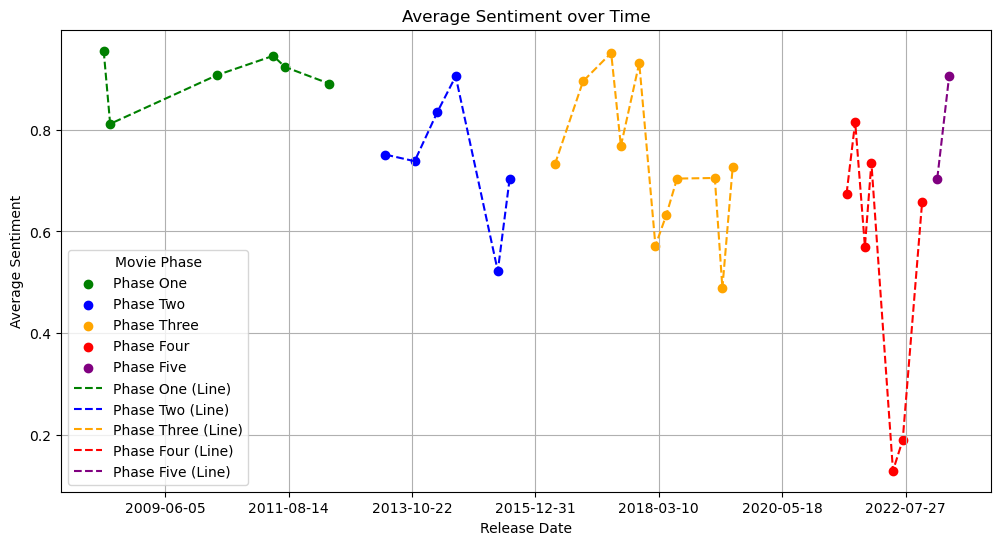

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming all_movie_sentiments, df, and movie_reviews are already defined

# Create a new column in the DataFrame to store the release date information
df['Release_Date'] = pd.to_datetime(df['U.S. release date'], errors='coerce')

# Create a list to store data points for plotting
data_points = []

# Create a dictionary to map phases to colors
phase_colors = {'Phase One': 'green', 'Phase Two': 'blue', 'Phase Three': 'orange', 'Phase Four': 'red', 'Phase Five': 'purple'}

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate through movies in the DataFrame
for index, row in df.iterrows():
    movie_title = row['Film']
    release_date = row['Release_Date']
    movie_phase = row['Phase']

    # Check if sentiment data is available for the current movie
    if movie_title in all_movie_sentiments:
        sentiment = all_movie_sentiments[movie_title]

        # Append the data point (release date, sentiment, phase) to the list
        data_points.append((release_date, sentiment, movie_phase))

# Sort the data points by release date
sorted_data_points = sorted(data_points, key=lambda x: x[0])

# Extract release dates, sentiments, and phases for plotting
release_dates, sentiments, phases = zip(*sorted_data_points)

# Plot the scatter plot with color-coded points
for phase, color in phase_colors.items():
    phase_indices = [i for i, movie_phase in enumerate(phases) if movie_phase == phase]
    ax.scatter([release_dates[i] for i in phase_indices], [sentiments[i] for i in phase_indices], label=phase, color=color)

# Plot a line for each phase
for phase, color in phase_colors.items():
    phase_indices = [i for i, movie_phase in enumerate(phases) if movie_phase == phase]
    ax.plot([release_dates[i] for i in phase_indices], [sentiments[i] for i in phase_indices], label=f'{phase} (Line)', linestyle='--', color=color)

# Set regular date intervals on the horizontal axis
ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # You can adjust the number of ticks as needed

# Add labels and legend
ax.set_title('Average Sentiment over Time')
ax.set_xlabel('Release Date')
ax.set_ylabel('Average Sentiment')
ax.legend(title='Movie Phase')
ax.grid(True)
plt.show()

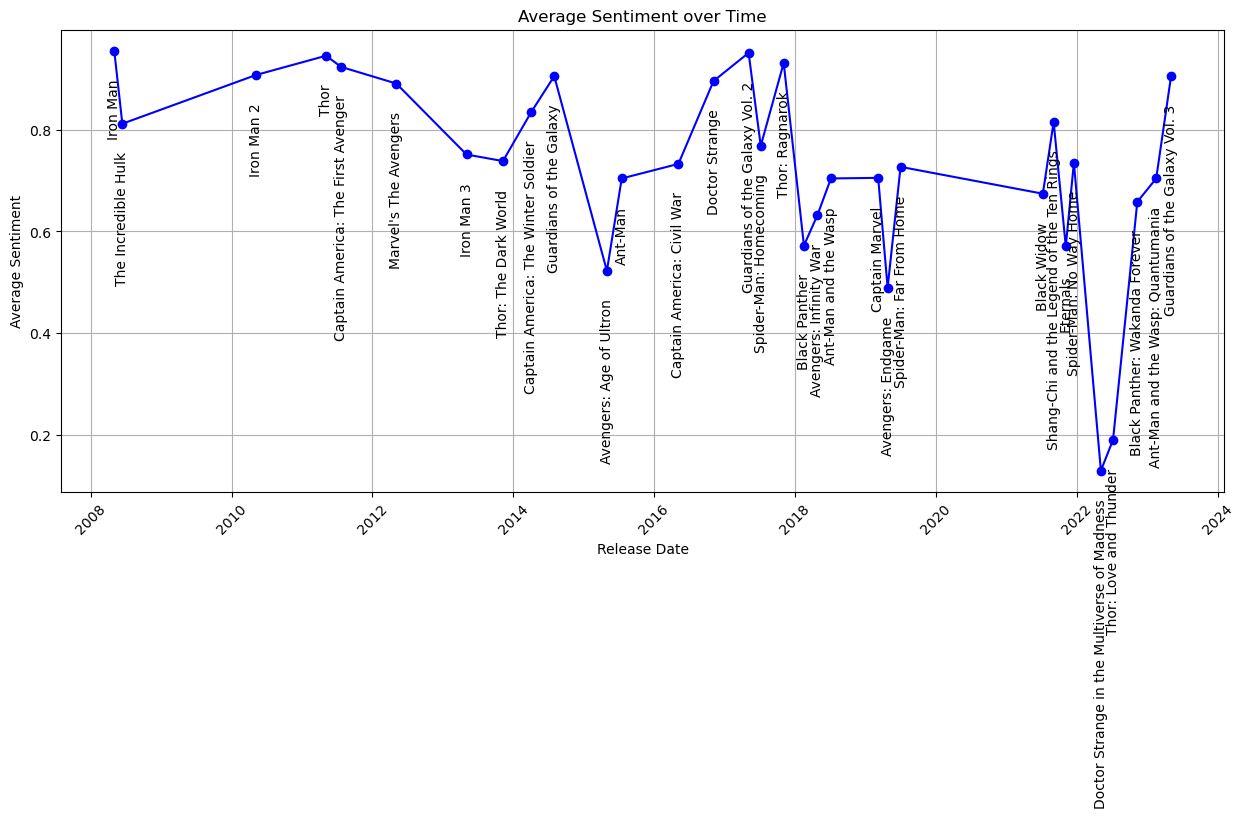

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming all_movie_sentiments, df, and movie_reviews are already defined

# Create a new column in the DataFrame to store the release date information
df['Release_Date'] = pd.to_datetime(df['U.S. release date'], errors='coerce')

# Create a list to store data points for plotting
data_points = []

# Iterate through movies in the DataFrame
for index, row in df.iterrows():
    movie_title = row['Film']
    release_date = row['Release_Date']

    # Check if sentiment data is available for the current movie
    if movie_title in all_movie_sentiments:
        sentiment = all_movie_sentiments[movie_title]

        # Append the data point (release date, sentiment, movie name) to the list
        data_points.append((release_date, sentiment, movie_title))

# Sort the data points by release date
sorted_data_points = sorted(data_points, key=lambda x: x[0])

# Extract release dates, sentiments, and movie names for plotting
release_dates, sentiments, movie_names = zip(*sorted_data_points)

# Plot the time series graph
plt.figure(figsize=(15, 6))
plt.plot(release_dates, sentiments, marker='o', linestyle='-', color='b')
plt.title('Average Sentiment over Time')
plt.xlabel('Release Date')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.grid(True)

# Add vertical labels for movie names below each data point
for date, sentiment, movie_name in zip(release_dates, sentiments, movie_names):
    plt.annotate(movie_name, xy=(date, sentiment), xytext=(0, -20), textcoords='offset points', rotation=90, ha='center', va='top')

plt.show()



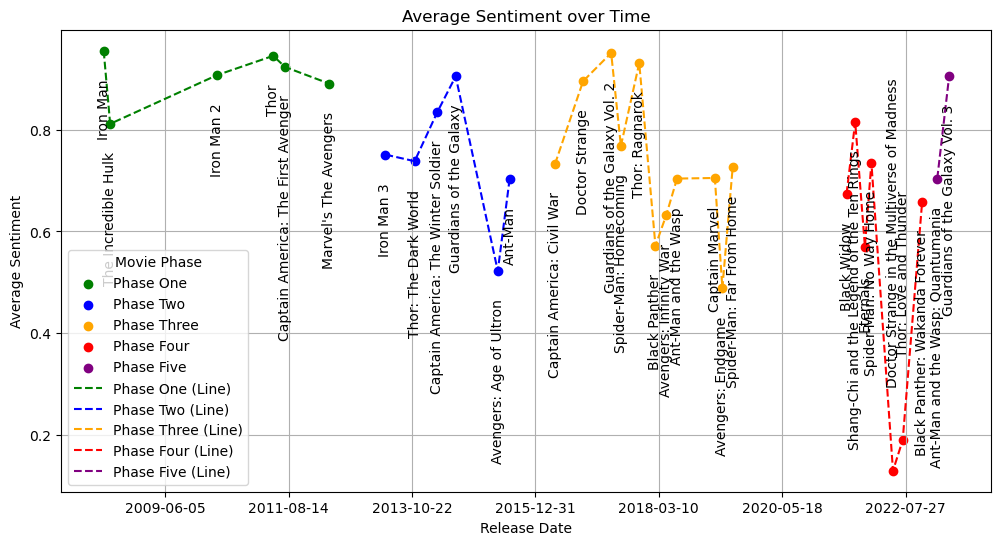

In [18]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 6))


for phase, color in phase_colors.items():
    phase_indices = [i for i, movie_phase in enumerate(phases) if movie_phase == phase]
    ax.scatter([release_dates[i] for i in phase_indices], [sentiments[i] for i in phase_indices], label=phase, color=color)

# Plot a line for each phase
for phase, color in phase_colors.items():
    phase_indices = [i for i, movie_phase in enumerate(phases) if movie_phase == phase]
    ax.plot([release_dates[i] for i in phase_indices], [sentiments[i] for i in phase_indices], label=f'{phase} (Line)', linestyle='--', color=color)

# Set regular date intervals on the horizontal axis
ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # You can adjust the number of ticks as needed

# Add labels and legend
ax.set_title('Average Sentiment over Time')
ax.set_xlabel('Release Date')
ax.set_ylabel('Average Sentiment')
ax.legend(title='Movie Phase')

# Add vertical labels for movie names below each data point
for date, sentiment, movie_name in zip(release_dates, sentiments, movie_names):
#     ax.annotate(movie_name, xy=(date, sentiment), xytext=(0, -20), textcoords='offset points', rotation=90, ha='center', va='top')
    if sentiment > 0.2:
        ax.annotate(movie_name, xy=(date, sentiment), xytext=(0, -20), textcoords='offset points', rotation=90, ha='center', va='top')
    else:
        ax.annotate(movie_name, xy=(date, sentiment), xytext=(0, 60), textcoords='offset points', rotation=90, ha='center', va='bottom')

ax.grid(True)
plt.show()


# Similarity Analysis

The code implements a document similarity detection method using minhashing and LSH. It first generates shingles from a list of words, then creates a signature matrix using minhashing. The matrix is divided into bands, and candidate pairs are identified using LSH. Finally, Jaccard similarity is calculated for candidate pairs, and pairs with similarity above a given threshold are considered similar documents. The approach aims to efficiently identify potential document pairs with high similarity while reducing computation costs.

# Shingling

In [19]:
import re

def shingle(words, k):
    shingles = []
    for i in range(len(words) - k + 1):
        shingles.append(" ".join(words[i:i+k]))
    return shingles

# MinHashing

In [20]:
import hashlib
from random import randint, seed

def get_hash_values(el, bytes_size, random_value):
    salt = chr(random_value)
    hash_objects = [hashlib.sha256((e + salt).encode('utf-16','surrogatepass')) for e in el]
    hv = [int(h.hexdigest()[:bytes_size], 16) for h in hash_objects]
    return hv

In [21]:
def get_signature_matrix(sets:int, els, bytes_size:int):
    sig_sets = []
    for s in range(sets):
        mh = []
        random_value = randint(0, 110000) #random value as salt to give hash function its uniqueness
        for el in els: #repeat for all documents/movie titles
            hashlist = get_hash_values(el, bytes_size, random_value)
            min_hash = min(hashlist) #get minimum of the hash values
            mh.append(min_hash) 
        sig_sets.append(mh)
    sig_matrix = list(map(list, zip(*sig_sets)))
    return sig_matrix

# Locality Sensitivity Hashing

In [22]:
def get_signature_matrix_bands(sig_matrix, b):
    length = len(sig_matrix[0])
    assert length % b == 0
    r = int(length/b) #number of rows in each band
    bands = {}
    for bn in range(b):
        band = [sig[bn*r:(bn+1)*r] for sig in sig_matrix]
        bands[bn] = band
    return bands

In [23]:
def band_buckets(band):
    buckets = {}
    for doc_id in range(len(band)):
        value = hash(str(band[doc_id]))
        if value not in buckets.keys():
            buckets[value] = []
        buckets[value].append(doc_id)      
    return buckets

In [24]:
import itertools

def find_candidate_pairs(buckets):
    cand_pairs = []
    for hash_value, doc_ids in buckets.items():
        if len(doc_ids) > 1:
            possible_pairs = list(map(lambda x: tuple(sorted(x)), itertools.combinations(doc_ids, 2)))
            cand_pairs.extend(possible_pairs)
    return set(cand_pairs)

In [25]:
def jaccard_similarity(list1, list2):
    s1, s2 = set(list1), set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

In [26]:
def check_similar_docs(sig_matrix, cand_pairs, threshold):
    similar_docs = []
    for cand_pair in cand_pairs:
        doc1, doc2 = cand_pair[0], cand_pair[1]
        sig1, sig2 = sig_matrix[doc1], sig_matrix[doc2]
        js = jaccard_similarity(sig1, sig2)
        if js >= threshold:
            similar_docs.append(tuple(sorted((doc1,doc2))))
    return set(similar_docs) if len(similar_docs) > 0 else None

In [27]:
# b cuts the signature into b sub vectors, the larger the value of b, the smaller the individual vectors 
# and hence the easier to match but less reliable as similarity measure
def get_similar_docs(sig_matrix, b, threshold):
    docs = []
    bands = get_signature_matrix_bands(sig_matrix, b)
    for bucket, band in bands.items():
        buckets = band_buckets(band)
        cand_pairs = find_candidate_pairs(buckets)
        doc = check_similar_docs(sig_matrix, cand_pairs, threshold)
        if doc != None:
            docs.extend(doc)
    return set(docs)

# Putting Everything Together

In [28]:
for title, reviews in movie_reviews.items():
    shingles = [shingle(preprocess_text(review, keep_adjectives_flag=False).split(),3) for review in reviews]
    sig_matrix = get_signature_matrix(300, shingles, 4) #number of hash functions and bytes-size
    similar_movie_reviews = get_similar_docs(sig_matrix, 100, 0.2) #number of buckets and threshold
    print(title, ": ", similar_movie_reviews)

Iron Man :  set()
The Incredible Hulk :  set()
Iron Man 2 :  set()
Thor :  set()
Captain America: The First Avenger :  set()
Marvel's The Avengers :  set()
Iron Man 3 :  set()
Thor: The Dark World :  set()
Captain America: The Winter Soldier :  set()
Guardians of the Galaxy :  set()
Avengers: Age of Ultron :  set()
Ant-Man :  set()
Captain America: Civil War :  set()
Doctor Strange :  set()
Guardians of the Galaxy Vol. 2 :  set()
Spider-Man: Homecoming :  set()
Thor: Ragnarok :  set()
Black Panther :  set()
Avengers: Infinity War :  set()
Ant-Man and the Wasp :  set()
Captain Marvel :  set()
Avengers: Endgame :  set()
Spider-Man: Far From Home :  set()
Black Widow :  set()
Shang-Chi and the Legend of the Ten Rings :  set()
Eternals :  set()
Spider-Man: No Way Home :  set()
Doctor Strange in the Multiverse of Madness :  set()
Thor: Love and Thunder :  set()
Black Panther: Wakanda Forever :  set()
Ant-Man and the Wasp: Quantumania :  set()
Guardians of the Galaxy Vol. 3 :  set()


# Word Embeddings and Cosine Similarity

The code uses Word2Vec embeddings to calculate the cosine similarity between pairs of movie reviews for each movie title. Pairs with a similarity above 0.8 are identified as similar, and the count of similar pairs is printed for each movie title.

In [29]:
from gensim.models import Word2Vec
import numpy as np

def get_word2vec_embeddings(text, model):
    words = preprocess_text(text, keep_adjectives_flag=False).split()
    embeddings = [model.wv[word] for word in words] #convert each word into embeddings
    return embeddings

In [30]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b.T)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    return dot_product / (norm_a * norm_b)

In [31]:
def cosine_similarity_between_reviews(review1, review2, model):
    embeddings1 = get_word2vec_embeddings(review1, model)
    embeddings2 = get_word2vec_embeddings(review2, model)

    mean_embedding1 = np.mean(embeddings1, axis=0).reshape(1, -1)
    mean_embedding2 = np.mean(embeddings2, axis=0).reshape(1, -1)

    similarity = cosine_similarity(mean_embedding1, mean_embedding2)

    return np.mean(similarity)

In [32]:
for title, reviews in movie_reviews.items():
    similar_reviews = []
    words = [preprocess_text(review, keep_adjectives_flag=False).split() for review in reviews]
    model = Word2Vec(words, min_count = 1, vector_size = 100, window = 5) #create word2vec model for all reviews per movie title
    for i in range(25):
        for j in range(i+1,25):
            similarity = cosine_similarity_between_reviews(reviews[i], reviews[j], model)
            if similarity > 0.8:
                similar_reviews.append((i,j))
    print(title,":",len(similar_reviews))

Iron Man : 192
The Incredible Hulk : 276
Iron Man 2 : 209
Thor : 165
Captain America: The First Avenger : 300
Marvel's The Avengers : 229
Iron Man 3 : 274
Thor: The Dark World : 15
Captain America: The Winter Soldier : 42
Guardians of the Galaxy : 25
Avengers: Age of Ultron : 238
Ant-Man : 212
Captain America: Civil War : 71
Doctor Strange : 9
Guardians of the Galaxy Vol. 2 : 34
Spider-Man: Homecoming : 15
Thor: Ragnarok : 232
Black Panther : 9
Avengers: Infinity War : 25
Ant-Man and the Wasp : 212
Captain Marvel : 1
Avengers: Endgame : 0
Spider-Man: Far From Home : 0
Black Widow : 4
Shang-Chi and the Legend of the Ten Rings : 0
Eternals : 0
Spider-Man: No Way Home : 7
Doctor Strange in the Multiverse of Madness : 8
Thor: Love and Thunder : 0
Black Panther: Wakanda Forever : 95
Ant-Man and the Wasp: Quantumania : 212
Guardians of the Galaxy Vol. 3 : 25


# TF IDF

The code processes a collection of movie reviews, calculates TF-IDF scores for the top 20 words in each movie's concatenated reviews, and prints the results. The TF-IDF scores provide insights into the importance of words within the context of individual movies, considering both the frequency of the words in each movie and their rarity across all movies.

### Helper Functions

In [33]:
import re
from collections import Counter
import math

def calculate_tf(text):
    words = text.split()
    word_count = Counter(words)

    # Check if word_count is not empty
    if word_count:
        most_common_count = word_count.most_common(1)[0][1]  # Get the count of the most common word
        tf = {word: count / most_common_count for word, count in word_count.items()}
        return tf
    else:
        # If word_count is empty, return an empty dictionary
        return {}


def calculate_idf(documents):
    total_documents = len(documents)
    idf = {}
    
    for document in documents:
        words = set(document.split())
        for word in words:
            idf[word] = idf.get(word, 0) + 1
    
    idf = {word: math.log(total_documents / (freq + 1)) for word, freq in idf.items()}
    return idf

def calculate_tfidf(tf, idf):
    tfidf = {word: tf.get(word, 0) * idf.get(word, 0) for word in set(tf) | set(idf)}
    return tfidf

def analyze_reviews(reviews):
#     processed_reviews = [preprocess_text(review) for review in reviews]
    idf = calculate_idf(reviews)

    for i, review in enumerate(reviews):
        tf = calculate_tf(review)
        tfidf = calculate_tfidf(tf, idf)
        
        print(f"\nTop 20 Words for Review {i + 1}:")
        sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:20]
        for word, value in sorted_tfidf:
            print(f"{word}: {value}")
        

### Helper function to concatenate all reviews for a single movie

In [34]:
all_movie_reviews = {}
for title, reviews in adj_reviews.items():
#     print(f"\nFor movie {title}:")
#     analyze_reviews(reviews)
    # Concatenate the list of reviews for each movie
    concatenated_reviews = ' '.join(reviews)
    
    # Add the concatenated reviews to the list
    all_movie_reviews[title] = concatenated_reviews
    
# all_movie_reviews

# Calculate TF-IDF 
### Note: Every Document refers to the concatenated version of all reviews for a single movie

In [35]:
def calculate_movie_tfidf(all_reviews):
#     processed_reviews = [preprocess_text(review) for review in all_reviews.values()]
#     idf = calculate_idf(processed_reviews)
    idf = calculate_idf(all_reviews.values())

    movie_tfidf_dict = {}
    for title, review in all_reviews.items():
        tf = calculate_tf(review)
        tfidf = calculate_tfidf(tf, idf)
#         print(tfidf)
        print(f"\nTF-IDF at movie level - Scores for Top 20 words found in {title}:")
        sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:20]
        for word, value in sorted_tfidf:
            print(f"{word}: {value}")
        movie_tfidf_dict[title] = tfidf
    return movie_tfidf_dict

# Concatenate all reviews for each movie
all_movie_tfidf = calculate_movie_tfidf(all_movie_reviews)


TF-IDF at movie level - Scores for Top 20 words found in Iron Man:
wealthy: 0.22907647878693066
afghan: 0.22907647878693066
anti: 0.19610654887024684
standard: 0.1876049693234969
thankless: 0.17887669175740523
smaller: 0.15271765252462044
military: 0.13415751881805393
terrorist: 0.1341575188180539
fellow: 0.1341575188180539
corrupt: 0.1341575188180539
recognizable: 0.1341575188180539
campy: 0.11976116066875007
witty: 0.11623052197912127
impressed: 0.11256298159409814
global: 0.10799847958526913
sheer: 0.10799847958526913
smart: 0.10089617876773278
advanced: 0.09805327443512342
rich: 0.09805327443512342
dowdy: 0.08943834587870261

TF-IDF at movie level - Scores for Top 20 words found in The Incredible Hulk:
green: 0.24424594207722916
terrific: 0.2047242148495886
angry: 0.18504671974181286
responsible: 0.16139479187261024
chase: 0.16139479187261024
stronger: 0.1560410175245928
effective: 0.1441490142572167
fugitive: 0.12602676010180824
realistic: 0.11145786966042343
truthful: 0.10759652

## WordClouds based on TFIDF Scores for 'The Incredible Hulk', 'Iron Man 3', 'Captain America: The First Avenger'

Text(0.5, 1.0, 'The Incredible Hulk Reviews Word Cloud')

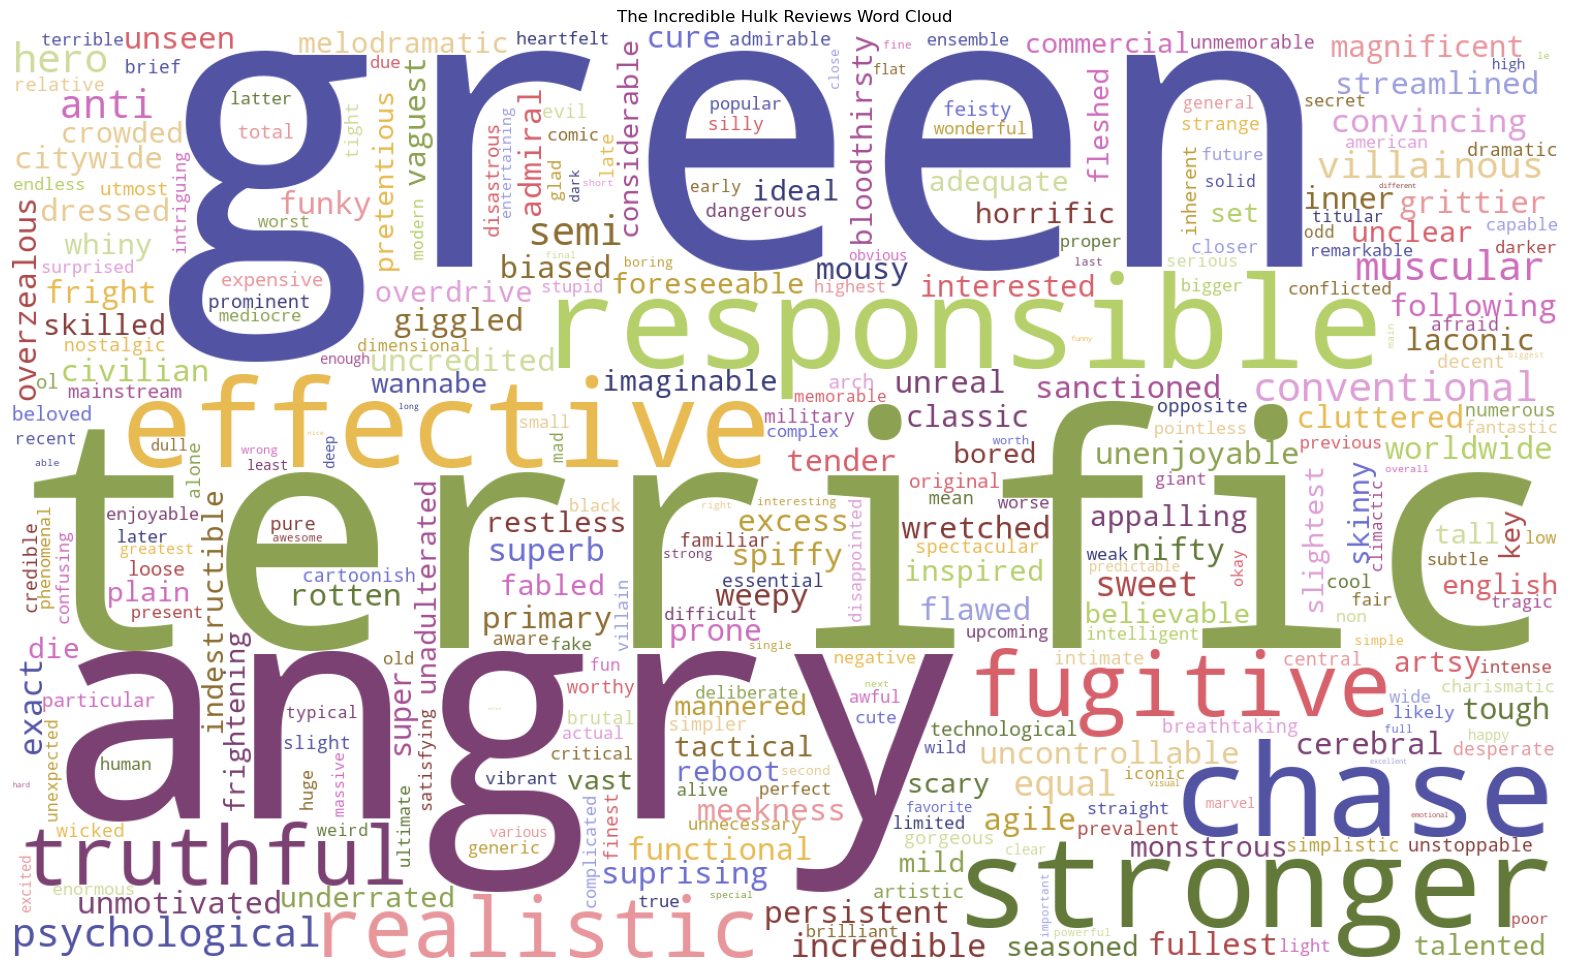

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

target_movie = 'The Incredible Hulk'
target_movie_tfidf = all_movie_tfidf[target_movie]

wc = WordCloud(width=1500, 
               height=900, 
               mode="RGBA", 
               colormap='tab20b', 
               background_color="white", 
               max_words=1000, 
               collocations=False
              ).fit_words(target_movie_tfidf)
plt.figure(figsize=(20,15))
plt.imshow(wc)
plt.axis("off")
plt.title("The Incredible Hulk Reviews Word Cloud")

Text(0.5, 1.0, 'Iron Man 3 Reviews Word Cloud')

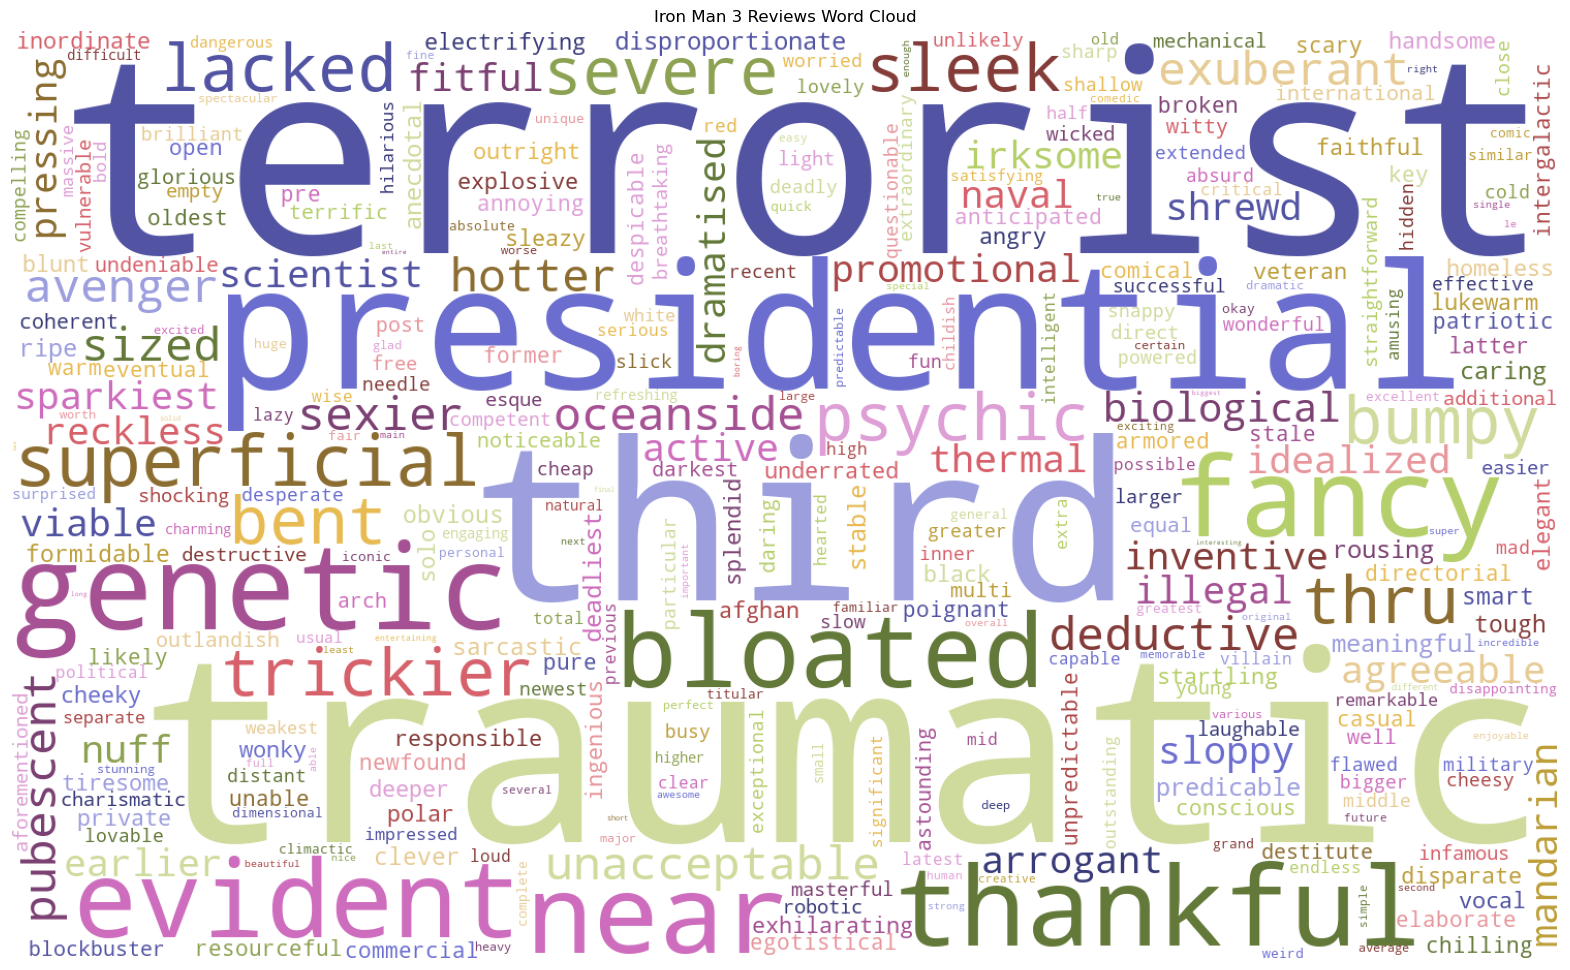

In [37]:
target_movie = 'Iron Man 3'
target_movie_tfidf = all_movie_tfidf[target_movie]

wc = WordCloud(width=1500, 
               height=900, 
               mode="RGBA", 
               colormap='tab20b', 
               background_color="white", 
               max_words=1000, 
               collocations=False
              ).fit_words(target_movie_tfidf)
plt.figure(figsize=(20,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Iron Man 3 Reviews Word Cloud")

Text(0.5, 1.0, 'Captain America: The First Avenger Reviews Word Cloud')

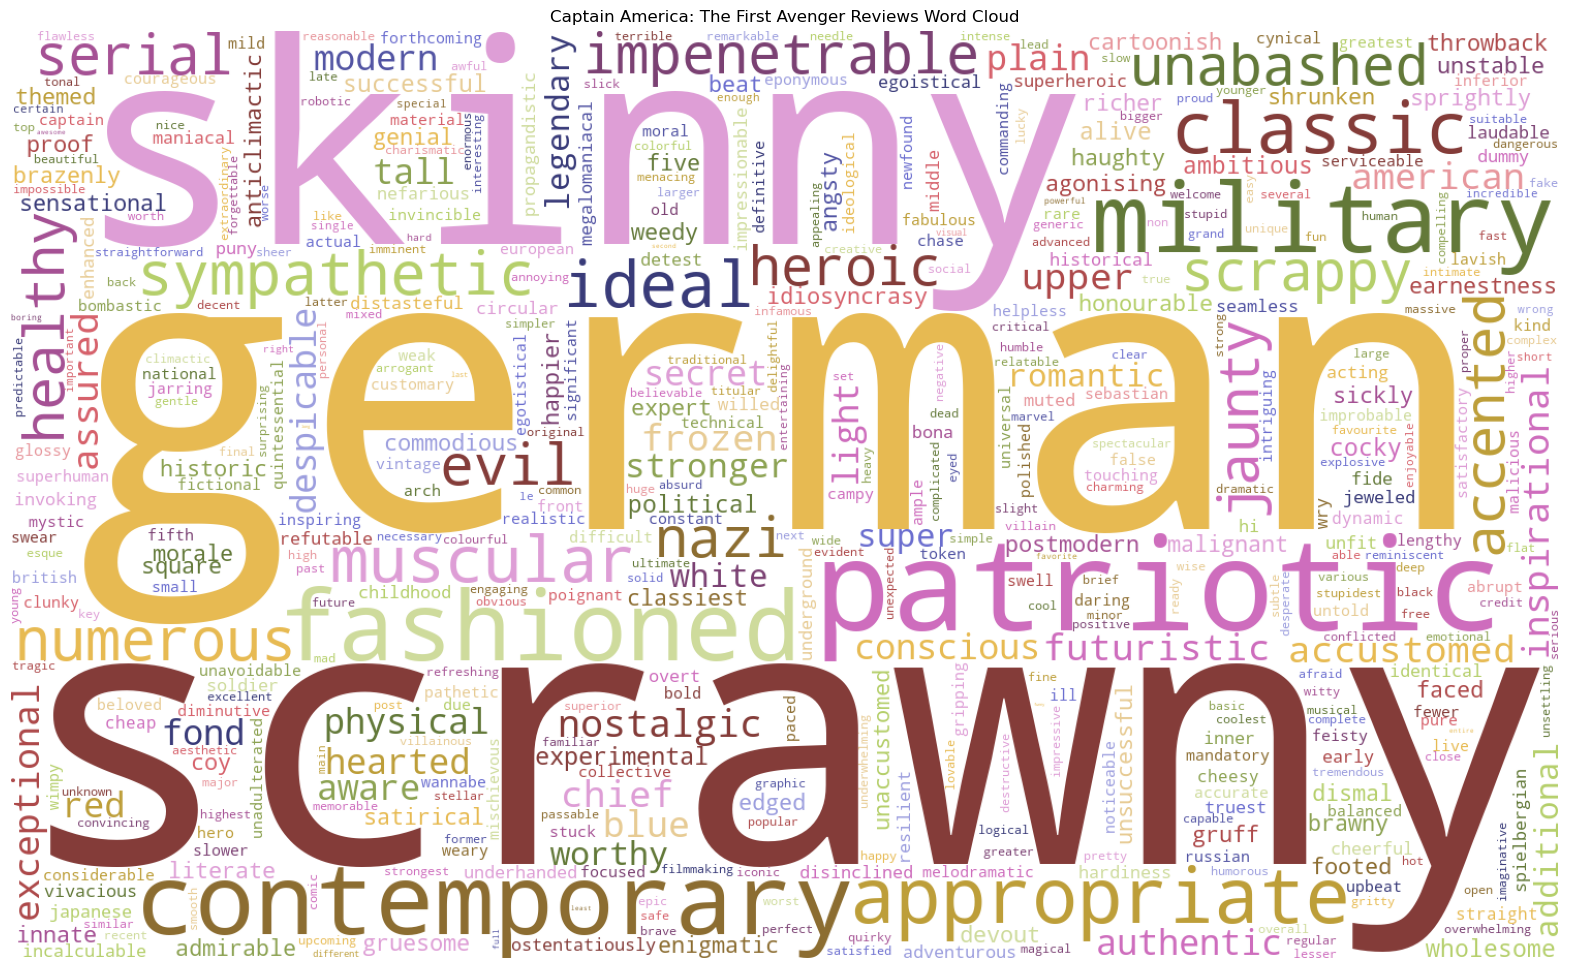

In [38]:
target_movie = 'Captain America: The First Avenger'
target_movie_tfidf = all_movie_tfidf[target_movie]

wc = WordCloud(width=1500, 
               height=900, 
               mode="RGBA", 
               colormap='tab20b', 
               background_color="white", 
               max_words=1000, 
               collocations=False
              ).fit_words(target_movie_tfidf)
plt.figure(figsize=(20,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Captain America: The First Avenger Reviews Word Cloud")